Training MAP model...
Fitting Laplace Approximation...
Computing Uncertainty Surfaces...


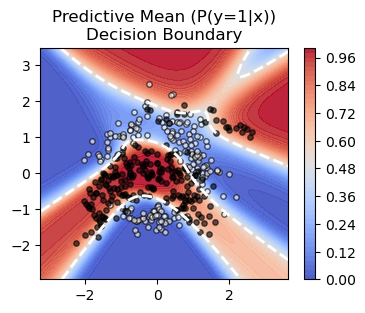

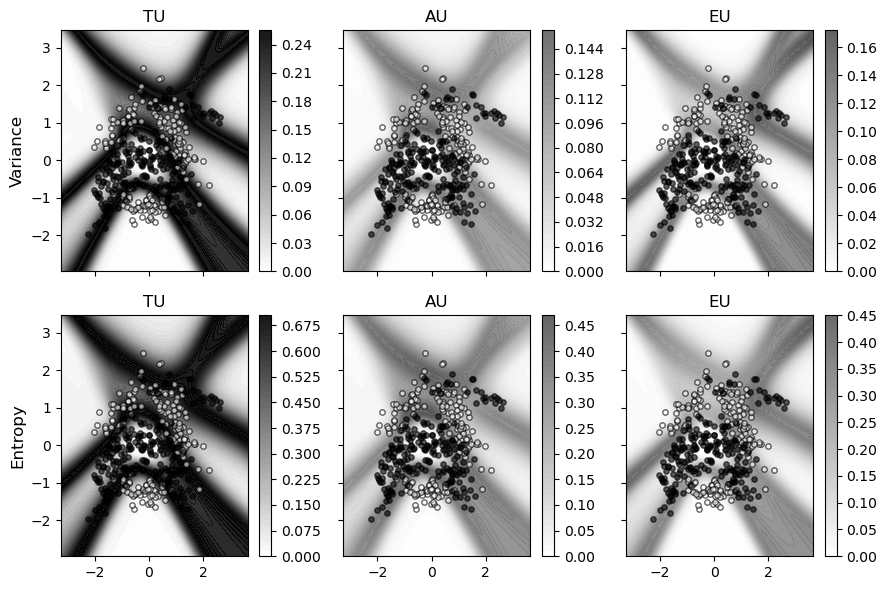

In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Try to import Laplace; handle if not installed
try:
    from laplace import Laplace
except ImportError:
    print("Error: 'laplace-torch' is not installed.")
    print("Please install it via: pip install laplace-torch")
    exit()

# ---------------------------------------------------------
# 1. Setup Data and Model (Same as your snippet)
# ---------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# X, y = make_moons(n_samples=1000, noise=0.3, random_state=0) # Reduced samples slightly for speed
X = np.loadtxt('data/banana_X.txt', delimiter=',', dtype=np.float32)
y = np.loadtxt('data/banana_Y.txt', dtype=np.float32)
X = X.astype(np.float32)
y = y.astype(np.int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

class SmallMLP(nn.Module):
    def __init__(self, in_dim=2, hidden=10, out_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, out_dim),
        )

    def forward(self, x):
        return self.net(x)

model = SmallMLP().to(device)

# ---------------------------------------------------------
# 2. Training (Standard MAP estimation)
# ---------------------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

print("Training MAP model...")
for epoch in range(100):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()

# ---------------------------------------------------------
# 3. Laplace Approximation
# ---------------------------------------------------------
print("Fitting Laplace Approximation...")
# subset_of_weights='all' matches your request for a full covariance (or diagonal)
# hessian_structure='full' is computationally expensive, 'kron' or 'diag' is preferred usually.
# We will use 'last_layer' or 'all' depending on preference. 
# Using 'all' with 'diag' structure for stability and speed on this dataset.
la = Laplace(model, 'classification', subset_of_weights='all', hessian_structure='diag')
la.fit(train_loader)

# ---------------------------------------------------------
# 4. Uncertainty Decomposition (Law of Total Variance)
# ---------------------------------------------------------
print("Computing Uncertainty Surfaces...")

# Create Grid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
grid_t = torch.from_numpy(grid).to(device)

# --- SAMPLING ---
# Instead of predictive_samples_glm, we use 'nn' (Neural Network) prediction type.
# This performs Monte Carlo integration: sampling weights from the posterior 
# and running the full model forward pass.
# Returns shape: (n_samples, batch_size, n_classes)
n_samples = 1000
predictive_probs = la.predictive_samples(
    grid_t, 
    n_samples=n_samples, 
    pred_type='glm'
)

def compute_uncertainties(predictive_probs, type='variance'):
    probs_class_1 = predictive_probs[:, :, 1]
    # 1. Predictive Mean (p_bar): E[p(y=1|x, theta)]
    p_bar = probs_class_1.mean(dim=0)
    if type == 'variance':
        # 2. Aleatoric Uncertainty: E[Var(y|x, theta)]
        # For binary classification, variance of a single model is p*(1-p)
        # We calculate this for every sample, then average.
        aleatoric_per_sample = probs_class_1 * (1 - probs_class_1)
        au = aleatoric_per_sample.mean(dim=0)
        
        # 3. Epistemic Uncertainty: Var[E(y|x, theta)]
        # This is the variance of the predictions p across the MC samples.
        # (How much the models disagree with each other)
        eu = probs_class_1.var(dim=0, unbiased=False) 
        
        # 4. Total Uncertainty: Var(y|x)
        # Can be calculated as Aleatoric + Epistemic
        # OR directly as p_bar * (1 - p_bar)
        tu = au + eu
    elif type == 'entropy':
        p_bar = probs_class_1.mean(dim=0)
        tu = - (p_bar * torch.log(p_bar + 1e-10) + (1 - p_bar) * torch.log(1 - p_bar + 1e-10))
        au = - (probs_class_1 * torch.log(probs_class_1 + 1e-10) + (1 - probs_class_1) * torch.log(1 - probs_class_1 + 1e-10)).mean(dim=0)
        eu = tu - au
    return tu, au, eu

# ---------------------------------------------------------
# 5. Plotting
# ---------------------------------------------------------
probs_class_1 = predictive_probs[:, :, 1] # for plotting
p_bar = probs_class_1.mean(dim=0) # for plotting
shape = xx.shape
mean_grid = p_bar.cpu().reshape(shape)
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
cmap_unc = 'gray_r'
cmap_mean = 'coolwarm' # Diverging map for probability

def plot_surface(ax, data, title, cmap, vmin=0, vmax=None, label=''):
    c = ax.contourf(xx, yy, data, levels=50, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.9)
    # Plot data points
    ax.scatter(X[y==0, 0], X[y==0, 1], c='white', edgecolors='k', s=15, alpha=0.6, label='Class 0')
    ax.scatter(X[y==1, 0], X[y==1, 1], c='black', edgecolors='k', s=15, alpha=0.6, label='Class 1')
    ax.set_title(title, fontsize=12)
    plt.colorbar(c, ax=ax, label=label)
    return c

plot_surface(ax, mean_grid, 'Predictive Mean (P(y=1|x))\nDecision Boundary', cmap_mean, 0, 1)
ax.contour(xx, yy, mean_grid, levels=[0.5], colors='white', linewidths=2, linestyles='--')
plt.show()

# Uncertainty Surfaces
var_total, var_aleatoric, var_epistemic = compute_uncertainties(predictive_probs, type='variance')   
ent_total, ent_aleatoric, ent_epistemic = compute_uncertainties(predictive_probs, type='entropy')
vmax_unc = 0.25 # Max variance for binary is 0.25
emax_unc = np.log(2) # Max entropy for binary is log(0.5)

# Reshape for plotting
total_var_grid = var_total.cpu().reshape(shape)
aleatoric_var_grid = var_aleatoric.cpu().reshape(shape)
epistemic_var_grid = var_epistemic.cpu().reshape(shape)
total_ent_grid = ent_total.cpu().reshape(shape)
aleatoric_ent_grid = ent_aleatoric.cpu().reshape(shape)
epistemic_ent_grid = ent_epistemic.cpu().reshape(shape)

fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(9, 6))
axs = axs.flatten()
plot_surface(axs[0], total_var_grid, 'TU', cmap_unc, 0, vmax_unc)
plot_surface(axs[1], aleatoric_var_grid, 'AU', cmap_unc, 0, vmax_unc)
plot_surface(axs[2], epistemic_var_grid, 'EU', cmap_unc, 0, vmax_unc)
plot_surface(axs[3], total_ent_grid, 'TU', cmap_unc, 0, emax_unc)
plot_surface(axs[4], aleatoric_ent_grid, 'AU', cmap_unc, 0, emax_unc)
plot_surface(axs[5], epistemic_ent_grid, 'EU', cmap_unc, 0, emax_unc)
axs[0].set_ylabel('Variance', fontsize=12)
axs[3].set_ylabel('Entropy', fontsize=12)

plt.tight_layout()
plt.show()

Plotting 20 decision boundaries sampled from the posterior...


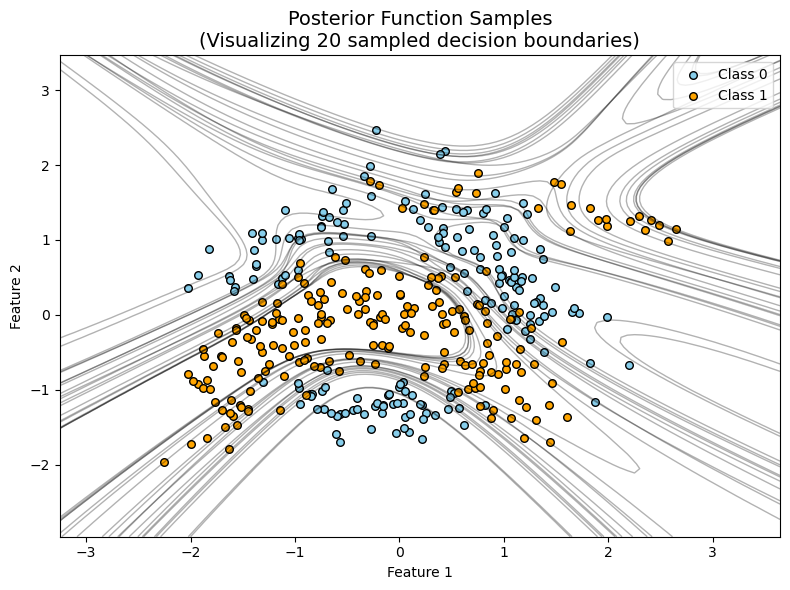

In [83]:
fig3, ax = plt.subplots(figsize=(8, 6))

# Plot data points
ax.scatter(X[y==0, 0], X[y==0, 1], c='skyblue', edgecolors='k', s=30, label='Class 0', zorder=2)
ax.scatter(X[y==1, 0], X[y==1, 1], c='orange', edgecolors='k', s=30, label='Class 1', zorder=2)

# Plot decision boundaries from the posterior samples
n_visualize = 20
print(f"Plotting {n_visualize} decision boundaries sampled from the posterior...")

# We iterate through the first n_visualize samples from our predictive_probs tensor
for i in range(n_visualize):
    # Extract the probability surface for the i-th sample
    p_sample = probs_class_1[i].cpu().reshape(xx.shape)
    
    # Draw the decision boundary (contour at 0.5) for this specific sample
    ax.contour(xx, yy, p_sample, levels=[0.5], colors='black', linewidths=1, alpha=0.3)

ax.set_title(f'Posterior Function Samples\n(Visualizing {n_visualize} sampled decision boundaries)', fontsize=14)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.legend(loc='upper right')
plt.tight_layout()

plt.show()


Computing Linearized Epistemic Uncertainty via J^T * Sigma * J...


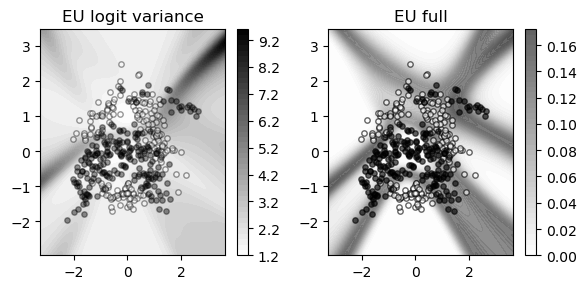

In [86]:
print("\nComputing Linearized Epistemic Uncertainty via J^T * Sigma * J...")
sigma_post = torch.diag(1/la.posterior_precision) # Only if covariance is diagonal

# 1. Compute Jacobian J(x) for the grid
# Returns shape: (n_grid_samples, n_classes, n_params)
# Using the backend to efficiently compute gradients
Js, _ = la.backend.jacobians(grid_t)

# We focus on the logits for Class 1 to see the variance
# J_c1: (N_grid, N_params)
J_c1 = Js[:, 1, :] 

# 3. Compute Variance: diag(J * Sigma * J^T)
# This formula projects the uncertainty "blob" from parameter space (Sigma)
# through the lens of the model's sensitivity (Jacobian) to the output.

# Efficient calculation: sum((J @ Sigma) * J, dim=1)
# H = J @ Sigma  --> (N, P)
H = torch.matmul(J_c1, sigma_post)

# var = row_sum(H * J) --> (N,)
var_logit_linearized = torch.sum(H * J_c1, dim=1)

# Reshape for plotting
var_logit_grid = var_logit_linearized.cpu().detach().numpy().reshape(xx.shape)

# 4. Plot
fig4, axs = plt.subplots(1, 2, figsize=(6, 3))
c = axs[0].contourf(xx, yy, var_logit_grid, levels=50, cmap='gray_r')
plt.colorbar(c, ax=axs[0])

axs[0].scatter(X[y==0, 0], X[y==0, 1], c='white', edgecolors='k', s=15, alpha=0.4)
axs[0].scatter(X[y==1, 0], X[y==1, 1], c='black', edgecolors='k', s=15, alpha=0.4)

axs[0].set_title('EU logit variance')
# + '\n' + r'$Var(f_{\text{lin}}^{\theta^*}(x,\theta)) = \left[\sigma(z)(1-\sigma(z))\right]J(x)^T \Sigma_{\theta} J(x) \approx J(x)^T \Sigma_{\theta} J(x)$', fontsize=14)
plot_surface(axs[1], epistemic_var_grid, 'EU full', cmap_unc, 0, vmax_unc)

plt.tight_layout()
plt.show()